# <center> Deep Learning Project:

## Members
> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 
> - __Pedro Moura Gomes__ (m20200322)

***

## Objective
- __The objective of this notebook is to perform hyperparameters tuning:__
- Some references:
   - https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
   - https://keras.io/guides/keras_tuner/getting_started/
   - https://keras.io/api/utils/serialization_utils/
   - https://www.tensorflow.org/tutorials/keras/keras_tuner
   - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

## Install Packages

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
# !pip install findspark
# !pip install tensorflow-addons

In [2]:
import time
t1 = time.perf_counter()

- __Importing the necessary libraries 📚:__

In [3]:
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import keras.backend as K
import tensorflow_addons as tfa

In [4]:
from keras.models import Model, Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau 
from keras import optimizers

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif 
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import IPython

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
SEED = 2022

Fixing the random number seed to ensure that the results are reproducible.

In [7]:
session = K.get_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [8]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='macro'),
                metricsObj.f1_score(yTrain, yPredTrain, average='macro'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='macro'),
               metricsObj.f1_score(yTest, yPredTest, average='macro'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results}, index=measures_list)
    return resultsDF

In [9]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [10]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [11]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y))
    mi /= mi.max()
    mi.index = X.columns
    mi = mi.sort_values(ascending=False)
    mi.plot.bar(figsize=(20, 6))
    plt.title("Feature univariate score")
    plt.ylabel('Mutual Information')
    plt.show();
    return mi

In [12]:
def FTestScores(X, y):
    f_scores = pd.Series(-np.log10(f_classif(X, y)[1]))
    f_scores /= f_scores.max()
    f_scores.index = X.columns
    f_scores = f_scores.sort_values(ascending=False)
    f_scores.plot.bar(figsize=(20,6))
    plt.title("Feature univariate score")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show()
    return f_scores

In [13]:
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    return p

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    r = tp / (tp + fn + K.epsilon())
    return r

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [14]:
def remove_correlated(X, threshold=0.9):
    corr = np.absolute(X.corr())
    i = 1
    for (index, row) in corr.iterrows():
        for col in corr.columns[i:]:
            if row[col] > 0.9:
                print(f"{index} vs. {col} are highly correlated {row[col]}")
        i += 1
        # Select upper triangle of correlation matrix
    corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find features with correlation greater than threshold
    correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > threshold)]
    # Drop correlated columns
    return correlated_cols

In [15]:
def remove_outliers(x_train, x_test, y_train, y_test, estimators=100):
    isolation_forest = IsolationForest(n_estimators=estimators, random_state=SEED)
    
    #identify outliers:
    y_train_pred = isolation_forest.fit_predict(x_train)
    y_test_pred = isolation_forest.predict(x_test)

    #Remove outliers where 1 represent inliers and -1 represent outliers:
    x_train = x_train[np.where(y_train_pred == 1, True, False)]
    x_test = x_test[np.where(y_test_pred == 1, True, False)]

    y_train = y_train[np.where(y_train_pred == 1, True, False)]
    y_test = y_test[np.where(y_test_pred == 1, True, False)] 
    return x_train, x_test, y_train, y_test

In [63]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_history(history, metrics, title):
    """
    history: history of the model.
    metrics: the metrics in history to plot.
    title: Title of the plot.
    """
    loss = history.history[metrics]
    val_loss = history.history[f"val_{metrics}"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label=f"Training {metrics}")
    plt.plot(epochs, val_loss, "b", label=f"Validation {metrics}")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metrics)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [64]:
def auc_plot(y_test, y_pred_test_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    auc_keras = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras), color="g")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

## Loading the dataset

In [18]:
ds= pd.read_csv("data.csv")

In [19]:
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [20]:
# Checking the shape of the dataset:

ds.shape

(6819, 96)

In [21]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

0

In [22]:
# Checking the type of the columns:

ds.dtypes

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object

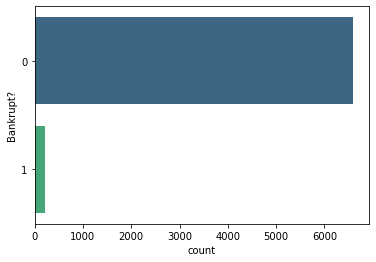

In [23]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h');

In [24]:
ds["Bankrupt?"].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

In [25]:
# MutualInfoScores(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])

In [26]:
X = ds.copy(deep=True)

y = X["Bankrupt?"]
X = X.drop(columns=["Bankrupt?"])

## Data Preparation

### Splitting the dataset

In [27]:
# Split the dataset intro train and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   shuffle = True, stratify=y, random_state=SEED)

### Correlation
We remove features whose absolute correlation coefficient are greater than 0.9

In [28]:
correlated_cols = remove_correlated(x_train)
x_train = x_train.drop(columns=correlated_cols)
x_test = x_test.drop(columns=correlated_cols)

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9418288508327729
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9861217517131242
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.957838380759818
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9564272011651113
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.9130270278033344
 Operating Gross Margin vs.  Realized Sales Gross Margin are highly correlated 0.9994625329796241
 Operating Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9999999896611498
 Realized Sales Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9994624071720175
 Operating Profit Rate vs.  Pre-tax net Intere

### Dealing with outliers:
Random forests is efficient at detecting outliers in high-dimensional dataset https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest. Isolation forest algorithm randomly selects a feature and splits it between the min and max. This process is repeated recuresively to partition the outliers

In [29]:
print(x_train.shape)
print(x_test.shape)

(4773, 73)
(2046, 73)


In [30]:
x_train, x_test, y_train, y_test = remove_outliers(x_train, x_test, y_train, y_test)

In [31]:
print(x_train.shape)
print(x_test.shape)

(4717, 73)
(2021, 73)


In [32]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.971168
1    0.028832
Name: Bankrupt?, dtype: float64
0    0.969322
1    0.030678
Name: Bankrupt?, dtype: float64


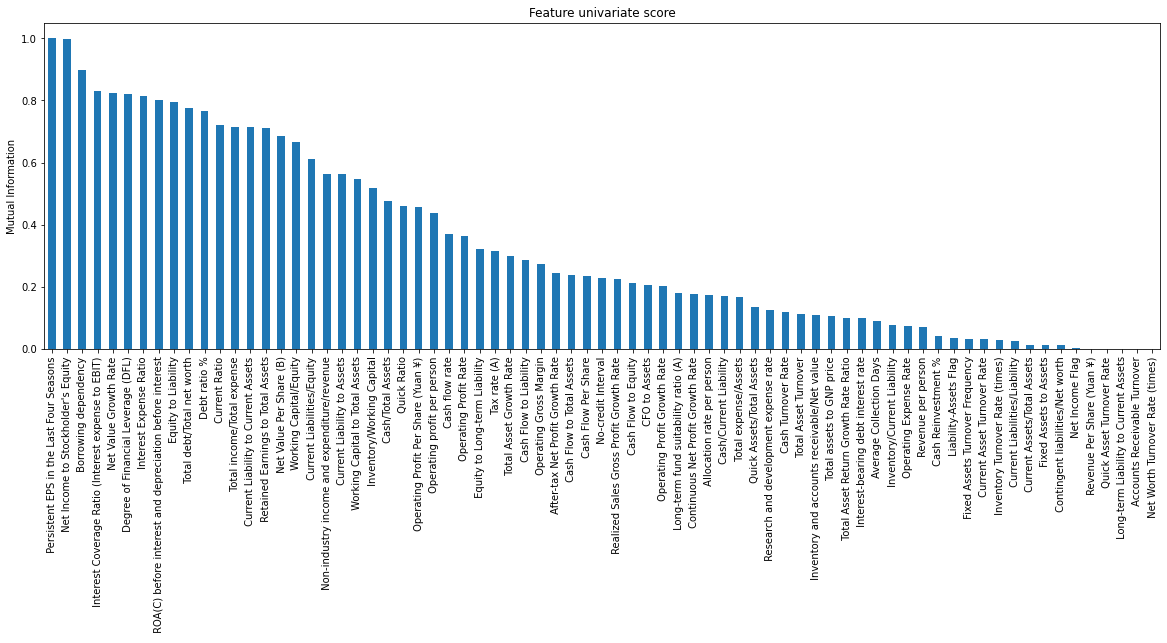

 Persistent EPS in the Last Four Seasons               1.000000
 Net Income to Stockholder's Equity                    0.998625
 Borrowing dependency                                  0.896846
 Interest Coverage Ratio (Interest expense to EBIT)    0.829523
 Net Value Growth Rate                                 0.824464
                                                         ...   
 Revenue Per Share (Yuan ¥)                            0.000000
 Quick Asset Turnover Rate                             0.000000
 Long-term Liability to Current Assets                 0.000000
 Accounts Receivable Turnover                          0.000000
 Net Worth Turnover Rate (times)                       0.000000
Length: 73, dtype: float64

In [33]:
MutualInfoScores(x_train, y_train)

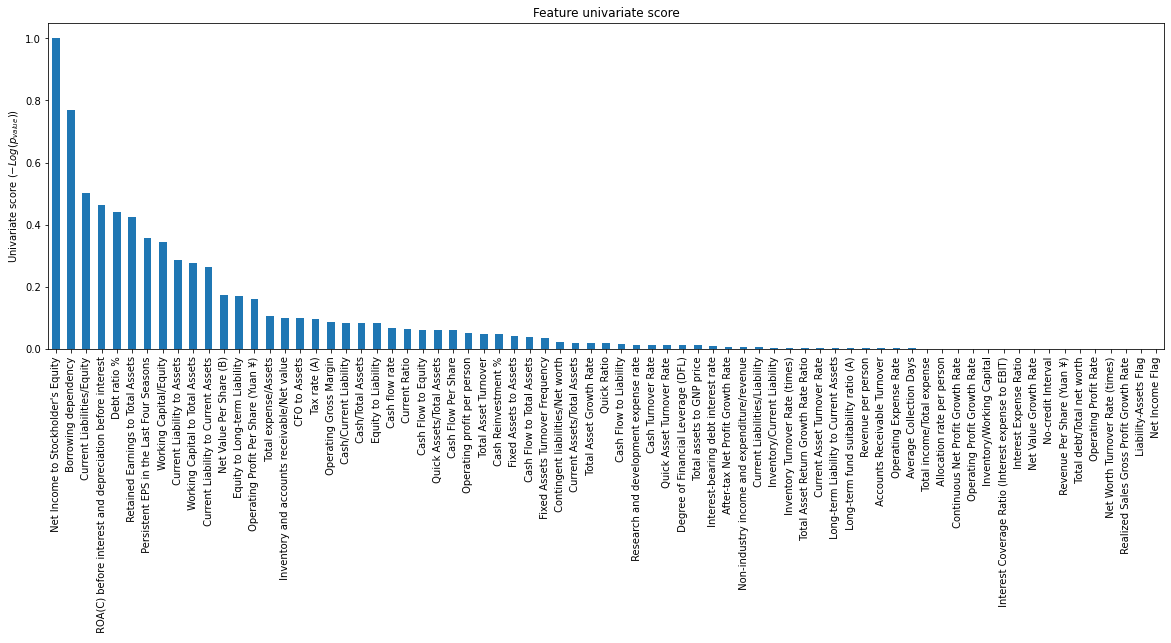

 Net Income to Stockholder's Equity                         1.000000
 Borrowing dependency                                       0.770567
 Current Liabilities/Equity                                 0.500427
 ROA(C) before interest and depreciation before interest    0.463902
 Debt ratio %                                               0.441154
 Retained Earnings to Total Assets                          0.425210
 Persistent EPS in the Last Four Seasons                    0.358444
 Working Capital/Equity                                     0.343314
 Current Liability to Assets                                0.285285
 Working Capital to Total Assets                            0.275719
 Current Liability to Current Assets                        0.264250
 Net Value Per Share (B)                                    0.173575
 Equity to Long-term Liability                              0.169901
 Operating Profit Per Share (Yuan ¥)                        0.159708
 Total expense/Assets             

In [34]:
f_scores = FTestScores(x_train, y_train)
f_scores.loc[f_scores > 0.1]

In [35]:
selector = SelectKBest(f_classif, k=len(f_scores.loc[f_scores > 0.1]))

# selecting the features:
selector.fit(x_train, y_train)

kept_columns = list(x_train.columns[selector.get_support()]) 

In [36]:
kept_columns

[' ROA(C) before interest and depreciation before interest',
 ' Net Value Per Share (B)',
 ' Persistent EPS in the Last Four Seasons',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Debt ratio %',
 ' Borrowing dependency',
 ' Working Capital to Total Assets',
 ' Current Liability to Assets',
 ' Working Capital/Equity',
 ' Current Liabilities/Equity',
 ' Retained Earnings to Total Assets',
 ' Total expense/Assets',
 ' Equity to Long-term Liability',
 ' Current Liability to Current Assets',
 " Net Income to Stockholder's Equity"]

In [37]:
x_train = x_train[kept_columns]
x_test = x_test[kept_columns]

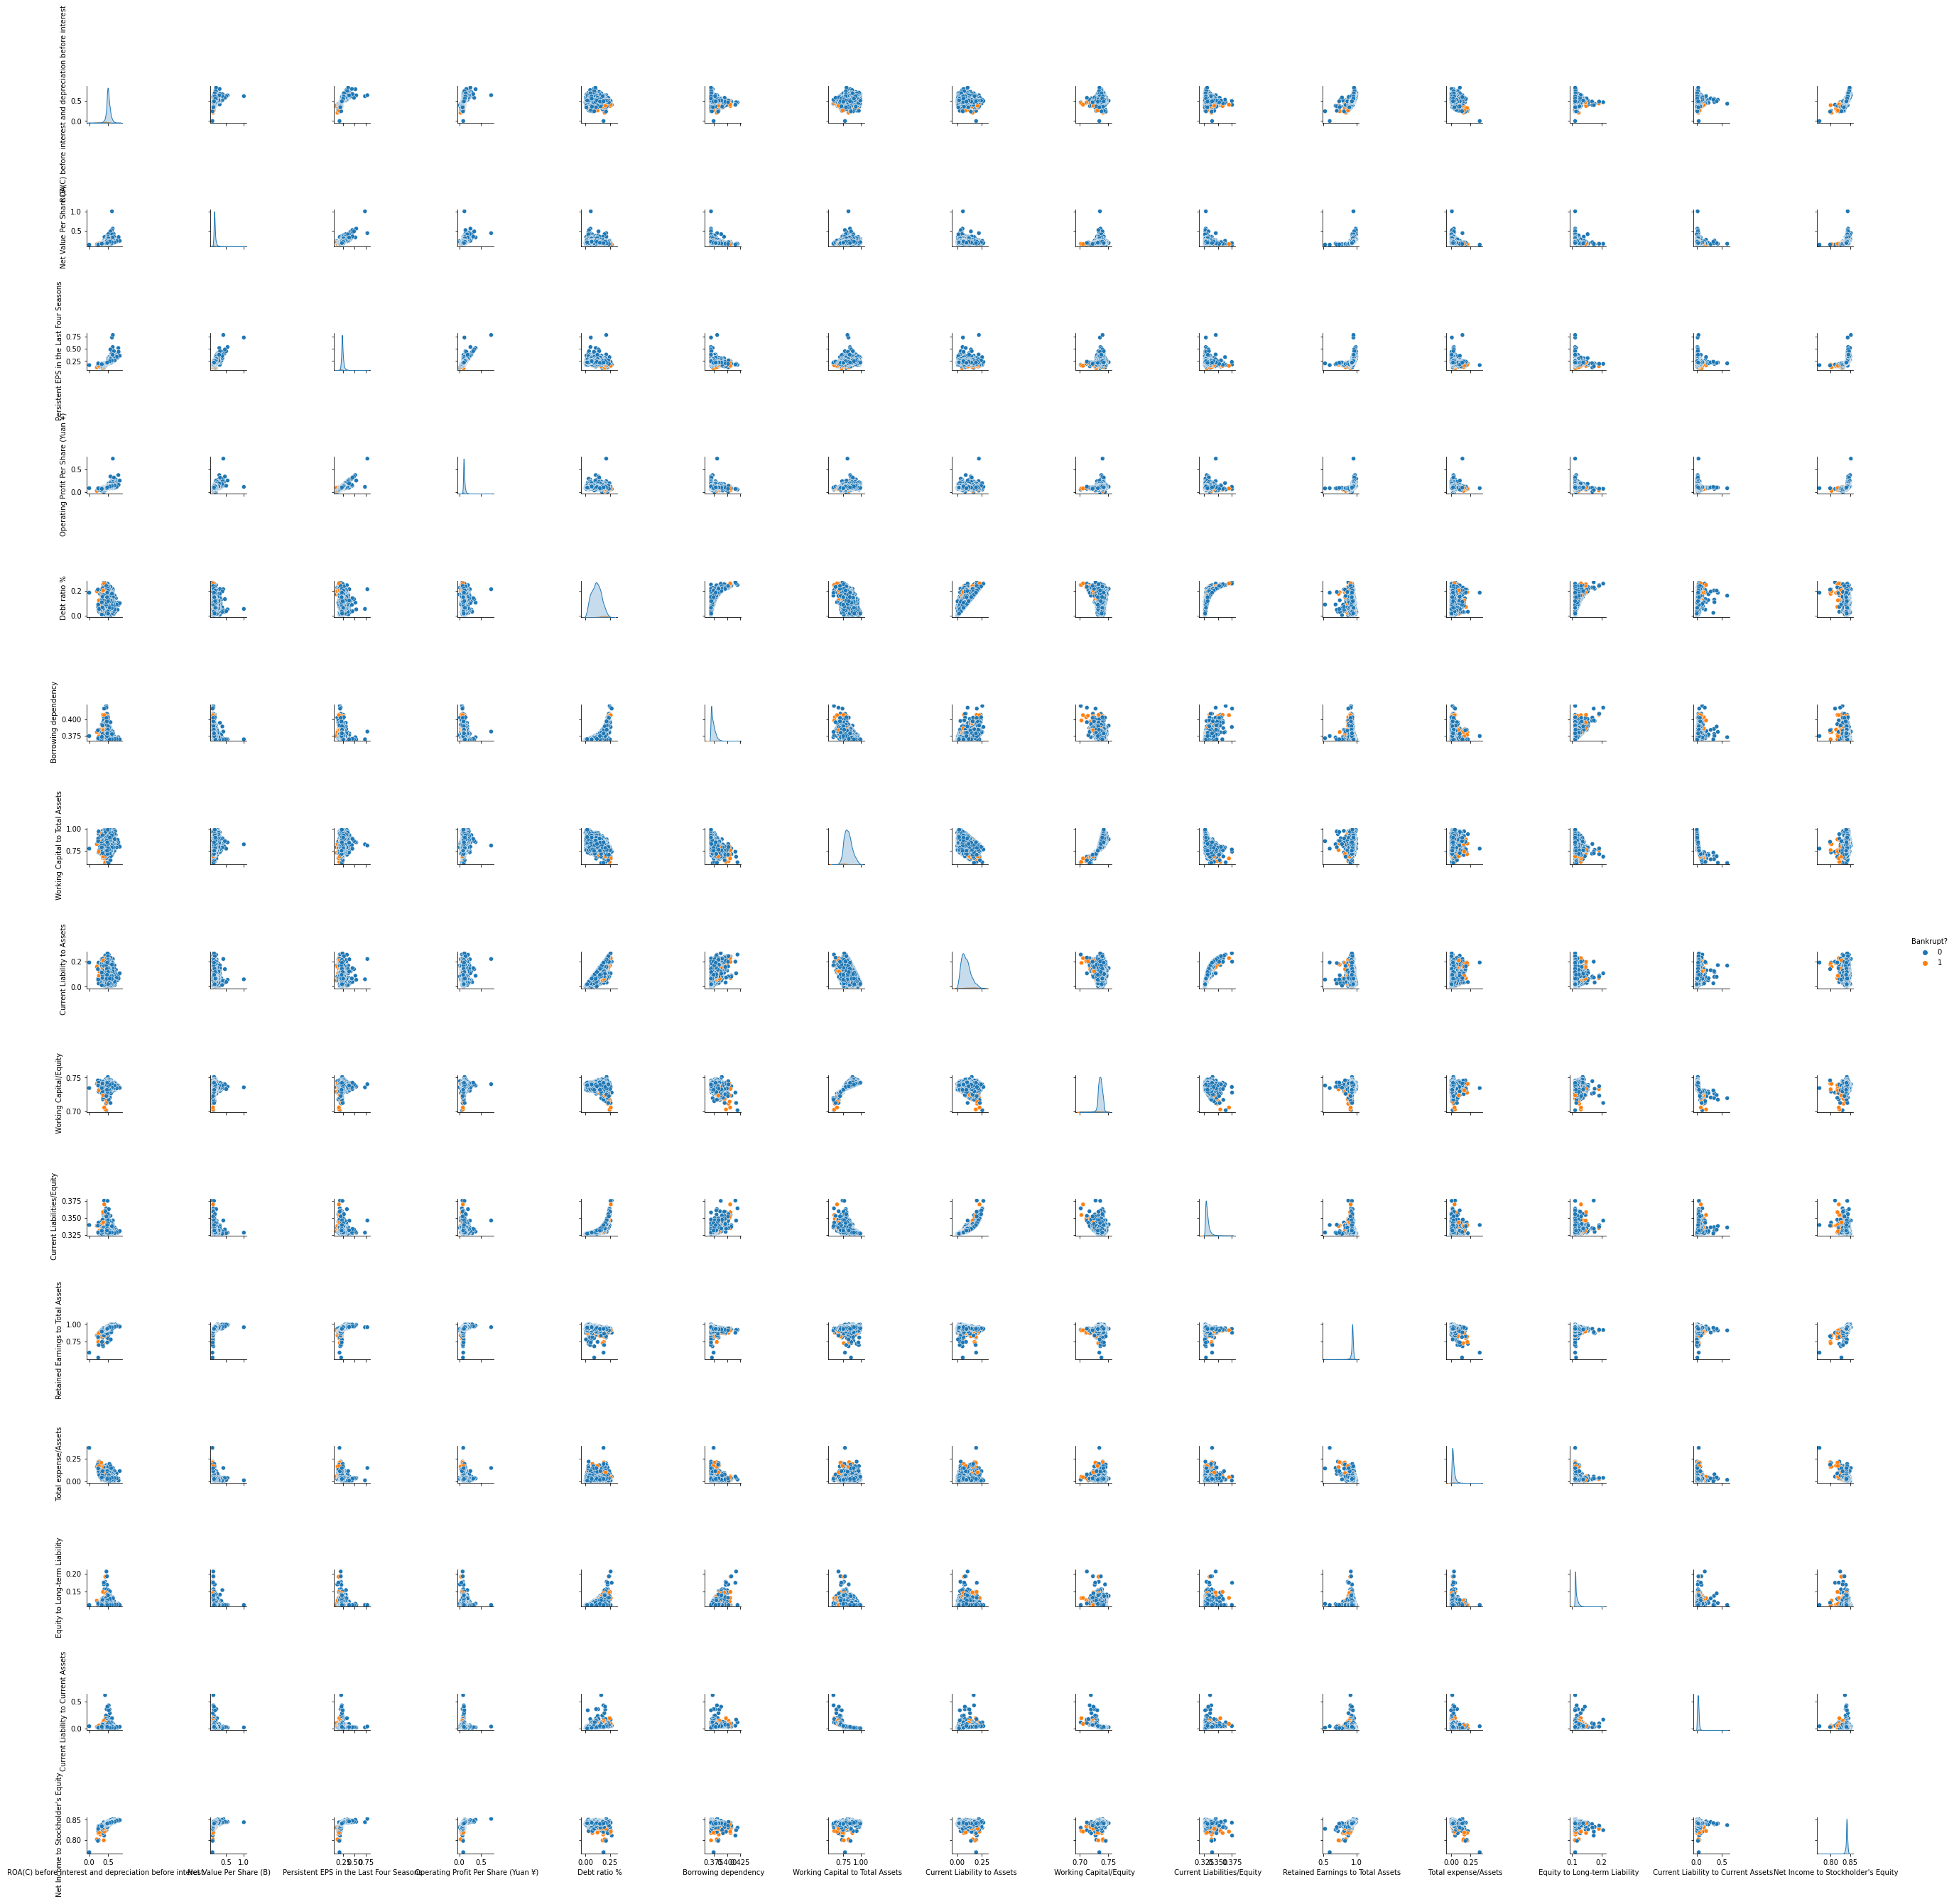

In [46]:
sns.pairplot(pd.concat([x_train, y_train], axis=1), hue="Bankrupt?")

## Data Normalization:

In [38]:
# We use the standard scaler in order to normalize the data:

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_test = scaler.transform(x_test)

# Hyper parameters tuning:

__Using Keras tuner:__

In [39]:
ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
ClassWeights

{0: 0.5148439205413665, 1: 17.341911764705884}

In [40]:
tune_objective = 'val_precision'
EarlyStop = EarlyStopping(monitor=tune_objective, patience=5, verbose=0, restore_best_weights=True)

CallBacksList = [EarlyStop,]  

#### Focal Loss
https://towardsdatascience.com/focal-loss-a-better-alternative-for-cross-entropy-1d073d92d075 provides a good explanation. In essence focal loss function focuses on cases that are misclassfified, so it's useful when the classes are imbalanced. It takes a parameter gamma.

In [41]:
def kfold_split(x, y, k):
    x = np.array(x)
    y = np.array(y)
    kfold = StratifiedKFold(n_splits=k)
    x_train, x_val, y_train, y_val = [], [], [], []
    for train_index, val_index in kfold.split(x, y):
        x_train.append(x[train_index])
        x_val.append(x[val_index])
        # Need to use y directly because y_train is Series
        y_train.append(y[train_index])
        y_val.append(y[val_index])
    return x_train, x_val, y_train, y_val


class MyHyperModel(kt.HyperModel):
    def __init__(self, metrics=None, k=3):
        self.k = k
        if metrics:
            self.metrics = metrics
        else:
            self.metrics= [
                tf.keras.metrics.Accuracy(name="accuracy"), 
                tf.keras.metrics.AUC(name="auc"), 
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                f1
            ]

    def build(self ,hp):

        hp_units_1 = hp.Choice("Layer 1", [32, 48, 64])
        hp_units_2 = hp.Choice("Layer 2", [8, 16, 32]) # 64
        hp_units_3 = hp.Choice("Layer 3", [4, 8, 16]) # 32, 64, 16 
        hp_activation = hp.Choice("activation", ["sigmoid", "relu", "tanh"])
        hp_kernel_initializer = hp.Choice("kernel_initializer", ["glorot_uniform", "glorot_normal"])
        hp_learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
        hp_gamma = hp.Choice("Gamma", [0.0, 0.5, 1.0, 2.0])
        hp_dropout = hp.Choice("rate", [0.2, 0.35, 0.5])
        
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = hp_kernel_initializer,
                        kernel_regularizer = tf.keras.regularizers.L2(0.1),
                        activation = hp_activation,
                        input_dim = x_train.shape[-1]   
                           )) 
    
        # Tune whether to use dropout.
        if hp.Boolean("Dropout 1"):
            model.add(layers.Dropout(rate=hp_dropout))
    
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 2"):
            model.add(layers.Dropout(rate=hp_dropout))
            
        model.add(layers.Dense(units = hp_units_3, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 3"):
            model.add(layers.Dropout(rate=hp_dropout))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = hp_kernel_initializer,
                            activation="sigmoid"))
            
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate)
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics= self.metrics)
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = hp_gamma), 
                    metrics= self.metrics)
    
        return model

    def kfold_split(self, x, y):
        x = np.array(x)
        y = np.array(y)
        kfold = StratifiedKFold(n_splits=self.k)
        x_train, x_val, y_train, y_val = [], [], [], []
        for train_index, val_index in kfold.split(x, y):
            x_train.append(x[train_index])
            x_val.append(x[val_index])
            # Need to use y directly because y_train is Series
            y_train.append(y[train_index])
            y_val.append(y[val_index])
        return x_train, x_val, y_train, y_val


    def fit(self, hp, model, x, y, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64])
        
        measures = ['val_precision', 'val_recall', 'val_f1', 'val_auc']
        results = pd.DataFrame(index=range(self.k), columns=measures)
        x_train, x_val, y_train, y_val = kfold_split(x, y, self.k)
        for i in range(self.k):
            hist = None
            try:
                hist = model.fit(
                    x_train[i],
                    y_train[i],
                    # Tune whether to shuffle the data in each epoch.
                    shuffle=hp.Boolean("shuffle"),
                    validation_data=(x_val[i], y_val[i]),
                    batch_size = hp_batch_size,
                    class_weight = ClassWeights,
                    **kwargs,
                )
                for m in measures:
                    results.iloc[i][m] = hist.history[m][-1]

            except:
                results.iloc[i] = 0

        avg_measures = {}
        for m in measures:
            avg_measures[m] = results[m].mean()
        return avg_measures

In [46]:
tuner = kt.BayesianOptimization(
    hypermodel = MyHyperModel(),
    objective = kt.Objective(tune_objective, direction="max"), 
    seed = SEED,
    max_trials = 5,
    overwrite=True,
    directory = 'Deep_learning_project',
    project_name = "Default_predictions"
)

In [48]:
tuner.search(x_train, y_train,
             epochs = 100,
             verbose = 2,
             initial_epoch = 0,
             callbacks = CallBacksList,
             use_multiprocessing = True,
            )

Trial 5 Complete [00h 00m 25s]
val_precision: 0.09400747964779536

Best val_precision So Far: 0.13656149307886759
Total elapsed time: 00h 02m 24s
INFO:tensorflow:Oracle triggered exit


In [49]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: {best_hps.get("Layer 1")}. \n
The second layer: {best_hps.get("Layer 2")}. \n
The third layer: {best_hps.get("Layer 3")}. \n
The activation function: {best_hps.get("activation")}. \n
The kernel initializer: {best_hps.get("kernel_initializer")}. \n
The loss function: {best_hps.get("loss_type")}. \n  
The learning rate: {best_hps.get("learning_rate")}. \n
The batch size: {best_hps.get("batch_size")}. \n
Dropout 1: {best_hps.get("Dropout 1")}. \n
Dropout 2: {best_hps.get("Dropout 2")}. \n
Dropout 3: {best_hps.get("Dropout 3")}. \n
Shuffle: {best_hps.get("shuffle")}. \n
Gamma: {best_hps.get("Gamma")}. \n
Dropout rate: {best_hps.get("rate")} \n
""")


The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: 64. 

The second layer: 16. 

The third layer: 8. 

The activation function: tanh. 

The kernel initializer: glorot_uniform. 

The loss function: FL. 
  
The learning rate: 0.00016468966822474475. 

The batch size: 16. 

Dropout 1: True. 

Dropout 2: True. 

Dropout 3: False. 

Shuffle: False. 

Gamma: 2.0. 

Dropout rate: 0.35 




In [51]:
best_model_params = MyHyperModel().build(best_hps)
best_model_params.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1024      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,209
Trainable params: 2,209
Non-traina

### Visualize Best Model K-fold Result

In [65]:
def visualize_kfold(model, x, y, k):
    metrics = ['loss', 'precision', 'recall', 'f1', 'auc']
    x_train, x_val, y_train, y_val = kfold_split(x, y, k)
    for i in range(k):
        hist = model.fit(x_train[i],
            y_train[i],
            epochs = 100,
            # Tune whether to shuffle the data in each epoch.
            shuffle= True,
            validation_data = (x_val[i], y_val[i]),
            batch_size = best_hps.get("batch_size"),
            class_weight = ClassWeights,
            callbacks = CallBacksList,
        )
        for m in metrics:
            if m == 'auc':
                y_pred_val_proba = model.predict(x_val[i])
                auc_plot(y_val[i], y_pred_val_proba)
            else:
                visualize_history(hist, m, f"Fold {i} {m}")


Epoch 1/100
236/236 [==============================] - 1s 5ms/step - loss: 0.2729 - accuracy: 0.0000e+00 - auc: 0.9251 - precision: 0.1498 - recall: 0.8716 - f1: 0.1827 - val_loss: 0.2514 - val_accuracy: 0.0000e+00 - val_auc: 0.9169 - val_precision: 0.1484 - val_recall: 0.8519 - val_f1: 0.2105
Epoch 2/100
236/236 [==============================] - 1s 5ms/step - loss: 0.2216 - accuracy: 0.0000e+00 - auc: 0.9298 - precision: 0.1511 - recall: 0.8624 - f1: 0.1994 - val_loss: 0.2045 - val_accuracy: 0.0000e+00 - val_auc: 0.9176 - val_precision: 0.1538 - val_recall: 0.8148 - val_f1: 0.2009
Epoch 3/100
236/236 [==============================] - 1s 5ms/step - loss: 0.1876 - accuracy: 0.0000e+00 - auc: 0.9294 - precision: 0.1621 - recall: 0.8165 - f1: 0.1966 - val_loss: 0.1730 - val_accuracy: 0.0000e+00 - val_auc: 0.9180 - val_precision: 0.1591 - val_recall: 0.7778 - val_f1: 0.1998
Epoch 4/100
236/236 [==============================] - 1s 5ms/step - loss: 0.1611 - accuracy: 0.0000e+00 - auc: 0.9

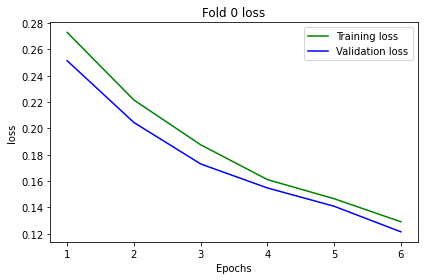

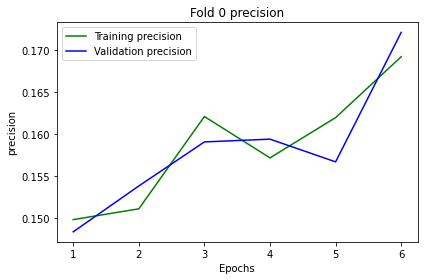

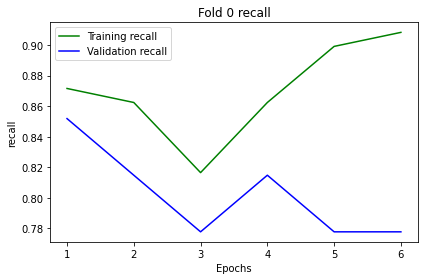

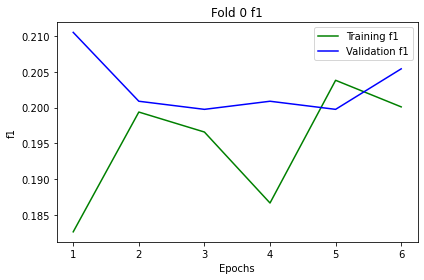

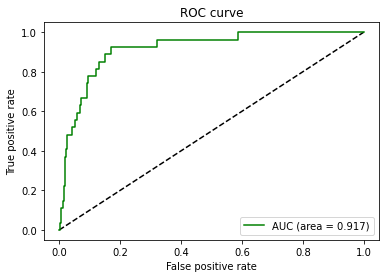

Epoch 1/100
236/236 [==============================] - 1s 4ms/step - loss: 0.2275 - accuracy: 0.0000e+00 - auc: 0.9203 - precision: 0.1461 - recall: 0.8241 - f1: 0.1727 - val_loss: 0.1986 - val_accuracy: 0.0000e+00 - val_auc: 0.9658 - val_precision: 0.2030 - val_recall: 0.9643 - val_f1: 0.2185
Epoch 2/100
236/236 [==============================] - 1s 5ms/step - loss: 0.1916 - accuracy: 0.0000e+00 - auc: 0.9236 - precision: 0.1582 - recall: 0.8889 - f1: 0.1978 - val_loss: 0.1717 - val_accuracy: 0.0000e+00 - val_auc: 0.9658 - val_precision: 0.1942 - val_recall: 0.9643 - val_f1: 0.2185
Epoch 3/100
236/236 [==============================] - 1s 5ms/step - loss: 0.1691 - accuracy: 0.0000e+00 - auc: 0.9208 - precision: 0.1579 - recall: 0.8333 - f1: 0.1939 - val_loss: 0.1536 - val_accuracy: 0.0000e+00 - val_auc: 0.9649 - val_precision: 0.1862 - val_recall: 0.9643 - val_f1: 0.2156
Epoch 4/100
236/236 [==============================] - 1s 5ms/step - loss: 0.1515 - accuracy: 0.0000e+00 - auc: 0.9

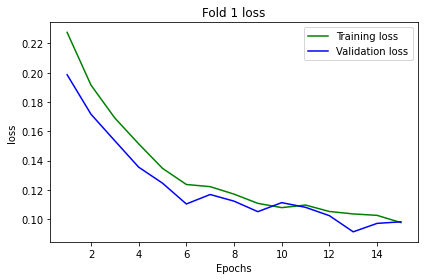

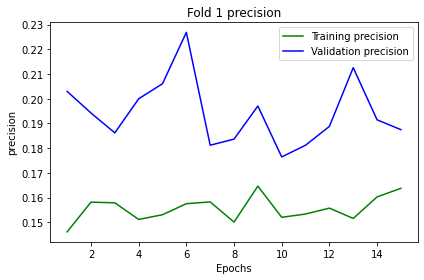

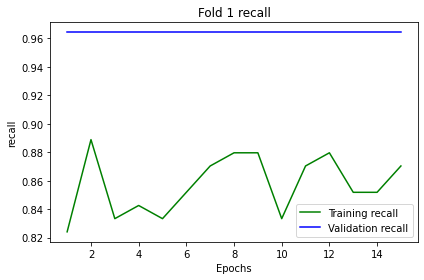

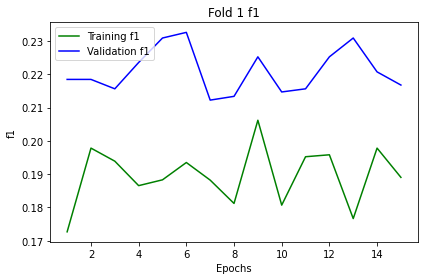

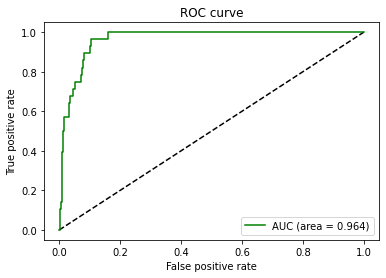

Epoch 1/100
236/236 [==============================] - 1s 5ms/step - loss: 0.1042 - accuracy: 0.0000e+00 - auc: 0.9300 - precision: 0.1609 - recall: 0.8991 - f1: 0.1856 - val_loss: 0.1051 - val_accuracy: 0.0000e+00 - val_auc: 0.9516 - val_precision: 0.1655 - val_recall: 0.8889 - val_f1: 0.1910
Epoch 2/100
236/236 [==============================] - 1s 4ms/step - loss: 0.1051 - accuracy: 0.0000e+00 - auc: 0.9258 - precision: 0.1575 - recall: 0.8899 - f1: 0.1984 - val_loss: 0.1022 - val_accuracy: 0.0000e+00 - val_auc: 0.9515 - val_precision: 0.1622 - val_recall: 0.8889 - val_f1: 0.1902
Epoch 3/100
236/236 [==============================] - 1s 4ms/step - loss: 0.1031 - accuracy: 0.0000e+00 - auc: 0.9263 - precision: 0.1541 - recall: 0.8624 - f1: 0.1750 - val_loss: 0.1013 - val_accuracy: 0.0000e+00 - val_auc: 0.9507 - val_precision: 0.1600 - val_recall: 0.8889 - val_f1: 0.1905
Epoch 4/100
236/236 [==============================] - 1s 5ms/step - loss: 0.0999 - accuracy: 0.0000e+00 - auc: 0.9

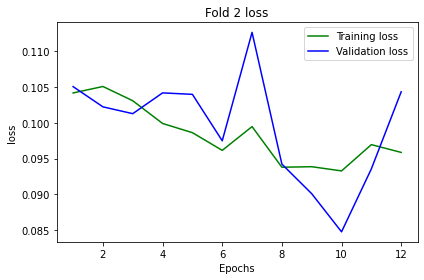

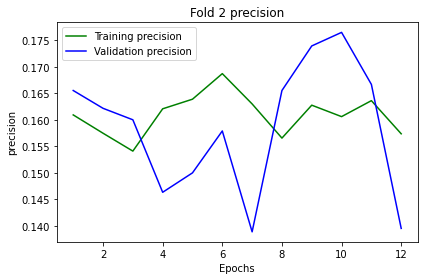

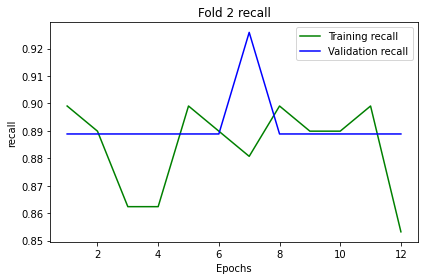

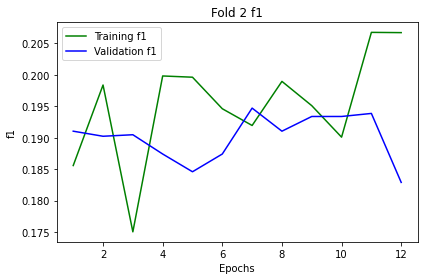

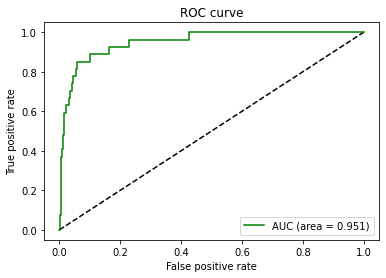

Epoch 1/100
236/236 [==============================] - 1s 5ms/step - loss: 0.0891 - accuracy: 0.0000e+00 - auc: 0.9419 - precision: 0.1639 - recall: 0.9083 - f1: 0.1940 - val_loss: 0.0942 - val_accuracy: 0.0000e+00 - val_auc: 0.9175 - val_precision: 0.1631 - val_recall: 0.8519 - val_f1: 0.2116
Epoch 2/100
236/236 [==============================] - 1s 5ms/step - loss: 0.0899 - accuracy: 0.0000e+00 - auc: 0.9405 - precision: 0.1720 - recall: 0.8807 - f1: 0.2054 - val_loss: 0.0883 - val_accuracy: 0.0000e+00 - val_auc: 0.9135 - val_precision: 0.1654 - val_recall: 0.8148 - val_f1: 0.2119
Epoch 3/100
236/236 [==============================] - 1s 4ms/step - loss: 0.0896 - accuracy: 0.0000e+00 - auc: 0.9399 - precision: 0.1655 - recall: 0.8899 - f1: 0.2100 - val_loss: 0.0878 - val_accuracy: 0.0000e+00 - val_auc: 0.9169 - val_precision: 0.1704 - val_recall: 0.8519 - val_f1: 0.2153
Epoch 4/100
236/236 [==============================] - 1s 5ms/step - loss: 0.0902 - accuracy: 0.0000e+00 - auc: 0.9

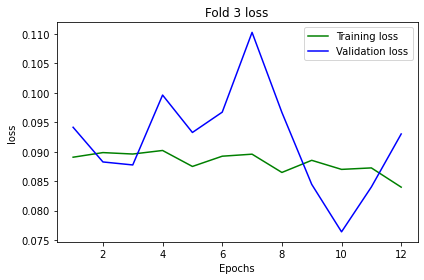

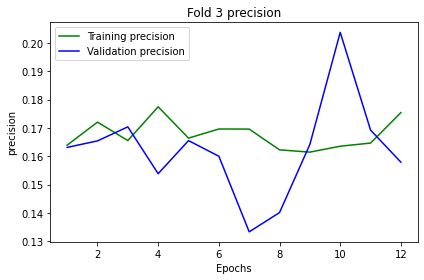

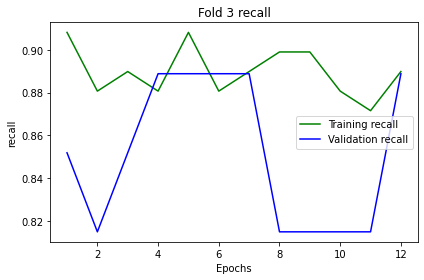

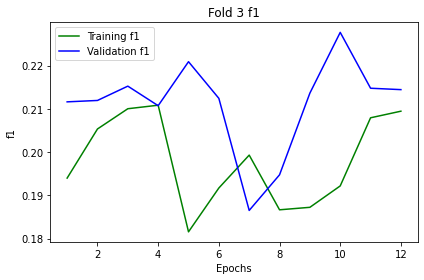

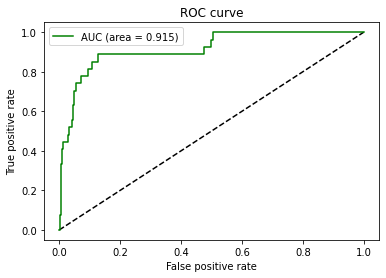

Epoch 1/100
236/236 [==============================] - 1s 5ms/step - loss: 0.0946 - accuracy: 0.0000e+00 - auc: 0.9311 - precision: 0.1667 - recall: 0.9083 - f1: 0.2012 - val_loss: 0.0873 - val_accuracy: 0.0000e+00 - val_auc: 0.9420 - val_precision: 0.1644 - val_recall: 0.8889 - val_f1: 0.1897
Epoch 2/100
236/236 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.0000e+00 - auc: 0.9363 - precision: 0.1679 - recall: 0.8532 - f1: 0.1868 - val_loss: 0.0927 - val_accuracy: 0.0000e+00 - val_auc: 0.9431 - val_precision: 0.1529 - val_recall: 0.8889 - val_f1: 0.1900
Epoch 3/100
236/236 [==============================] - 1s 6ms/step - loss: 0.0900 - accuracy: 0.0000e+00 - auc: 0.9370 - precision: 0.1672 - recall: 0.8899 - f1: 0.2050 - val_loss: 0.0927 - val_accuracy: 0.0000e+00 - val_auc: 0.9382 - val_precision: 0.1519 - val_recall: 0.8889 - val_f1: 0.1934
Epoch 4/100
236/236 [==============================] - 2s 7ms/step - loss: 0.0901 - accuracy: 0.0000e+00 - auc: 0.9

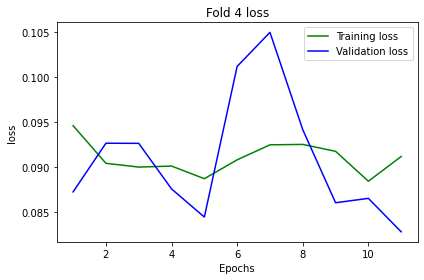

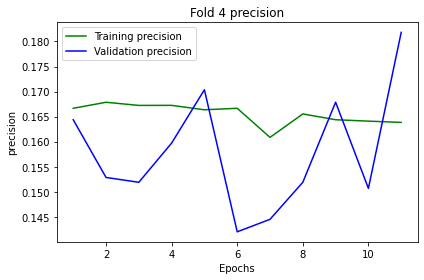

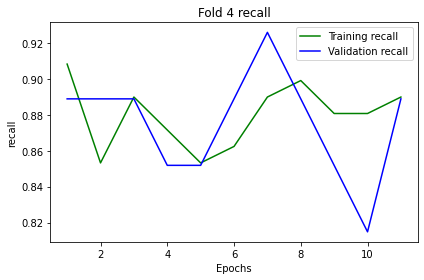

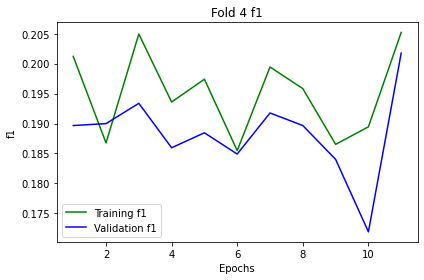

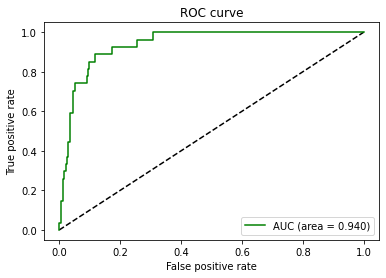

In [66]:
visualize_kfold(best_model_params, x_train, y_train, 5)

### Fit Model with All Training Data

In [60]:
best_model_params.fit(x_train,
    y_train,
    epochs = 100,
    # Tune whether to shuffle the data in each epoch.
    shuffle= True,
    batch_size = 64,
    class_weight = ClassWeights,
)

Epoch 1/100
74/74 [==============================] - 4s 9ms/step - loss: 2.3358 - accuracy: 0.0000e+00 - auc_1: 0.5317 - recall_1: 0.0441 - precision_1: 0.0526 - f1: 0.0233
Epoch 2/100
74/74 [==============================] - 0s 5ms/step - loss: 1.7145 - accuracy: 0.0000e+00 - auc_1: 0.7222 - recall_1: 0.5000 - precision_1: 0.0781 - f1: 0.1585
Epoch 3/100
74/74 [==============================] - 0s 6ms/step - loss: 1.2614 - accuracy: 0.0000e+00 - auc_1: 0.8126 - recall_1: 0.7059 - precision_1: 0.0848 - f1: 0.1776
Epoch 4/100
74/74 [==============================] - 0s 6ms/step - loss: 0.9304 - accuracy: 0.0000e+00 - auc_1: 0.8200 - recall_1: 0.7206 - precision_1: 0.0809 - f1: 0.1799
Epoch 5/100
74/74 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.0000e+00 - auc_1: 0.8078 - recall_1: 0.6691 - precision_1: 0.0827 - f1: 0.1701
Epoch 6/100
74/74 [==============================] - 0s 6ms/step - loss: 0.5218 - accuracy: 0.0000e+00 - auc_1: 0.8520 - recall_1: 0.74

In [61]:
best_model_params.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1024      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,649
Trainable params: 3,649
Non-trainable params: 0
_________________________________________________________________


In [62]:
y_pred_train = best_model_params.predict(x_train)
y_pred_test = best_model_params.predict(x_test)

In [63]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

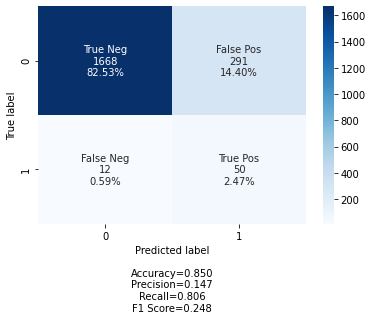

In [64]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [65]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

              precision    recall  f1-score   support

  No Default       0.99      0.85      0.92      1959
     Default       0.15      0.81      0.25        62

    accuracy                           0.85      2021
   macro avg       0.57      0.83      0.58      2021
weighted avg       0.97      0.85      0.90      2021



In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

In [ ]:
# NOTICE THE DIFFERENCE BETWENN THESE TWO MODELS ONE IS BUILT USING BEST_PARAMS,
# AND ONE USING GET_BEST_PARAMS THIS IS A WIERD SITUATION.

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

In [ ]:
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

In [ ]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

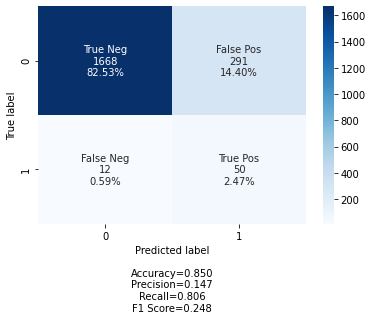

In [66]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

***

In [ ]:
t2 = time.perf_counter()
print('Time taken to run in minutes:',(t2-t1)/60.0)